In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
from utils import remove_items, split_data, group_color

In [3]:
def clean_df(csv_path="data/styles.csv"):
      """
      function to fetch and clean the data

      input : csv_path, path to .csv file
      return: styles, dataframe
      """

      styles = pd.read_csv(csv_path, on_bad_lines='skip')

      # drop unnecessary columns which are not needed to make recommendation
      styles = styles.drop(["productDisplayName"], axis=1) 
      styles = styles.drop(["year"], axis=1) 
      styles = styles[(styles.masterCategory=='Apparel')|(styles.masterCategory=='Footwear')]
      styles = styles.drop(styles[styles["subCategory"]=="Innerwear"].index)
      styles = styles.dropna()

      styles = remove_items(styles,"subCategory", ["Apparel Set", "Dress", "Loungewear and Nightwear", "Saree", "Socks"])
      styles["subCategory"] = styles["subCategory"].transform(lambda x: "Footwear" if (x in ["Shoes", "Flip Flops", "Sandal"]) else x)
      styles = styles.drop(labels = [6695, 16194, 32309, 36381, 40000], axis=0) # drop incomplete rows

      # group colors to the color-wheel
      group_color(styles) 

      return styles

In [4]:
styles = clean_df()
styles["subCategory"].unique() # sanity check after cleaning df: three subcategories

array(['Topwear', 'Bottomwear', 'Footwear'], dtype=object)

In [5]:
le = LabelEncoder()
styles["subCategory"] = le.fit_transform(styles["subCategory"])

In [6]:
def create_array(df):
      """
      function to fetch dataset 

      input : dataframe
      return: dataset
      """

      train_imgs = np.zeros((len(df.id), 80, 60, 3))

      for i in range(len(df.id)):      
        ID = df.id.iloc[i]
        img_path = f"data/images/{ID}.jpg"   
        img = cv2.imread(img_path)

        if img.shape != (80, 60, 3):
          img = image.load_img(img_path, target_size=(80, 60, 3))

        train_imgs[i] = img

      data = tf.data.Dataset.from_tensor_slices(
      (
        {
          "images": train_imgs
        },
        
        {
          "subCategory": df[["subCategory"]]
        }
      )
      )

      return data

In [7]:
def build_model(width, height, num_classes):
        """
        function to build model for subCategories

        input : width, image width 
                height, image height
                num_classes, number of classes
        return: keras.Model
        """

        resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(80, 60, 3))
        resnet50.trainable=False

        inputs = keras.Input(shape=(width,height,3), name="images")

        x = layers.RandomFlip("horizontal")(inputs)
        x = layers.RandomRotation(factor=0.2)(x)
        x = layers.RandomZoom(height_factor=0.1, width_factor=0.1)(x)
        x = layers.RandomContrast(factor=0.2)(x)

        x = resnet50(x, training=False)
        x = layers.Conv2D(32, (2, 2), activation='relu')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(len(num_classes))(x)
        x = layers.Activation('softmax', name='subCategory')(x)

        model = keras.Model(inputs=inputs, outputs=x)

        return model

In [8]:
batch_size = 32
epochs = 15

sub_train, sub_val, sub_test = split_data(create_array(styles), batch_size=batch_size)

sub_model = build_model(80, 60, num_classes=le.classes_)
sub_model.summary()

sub_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 80, 60, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 80, 60, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 80, 60, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 80, 60, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 80, 60, 3)        0         
 rast)                                                           
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        235877

In [9]:
plot_model(sub_model, to_file='model_category.png')

with tf.device("/gpu:0"):
    sub_history = sub_model.fit(sub_train, epochs=epochs, validation_data=sub_val)

Epoch 1/15


2022-07-18 16:37:04.981742: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


511/511 [==============================] - 187s 362ms/step - loss: 7.3626 - accuracy: 0.9202 - val_loss: 0.2998 - val_accuracy: 0.9824
Epoch 2/15
511/511 [==============================] - 183s 359ms/step - loss: 0.3412 - accuracy: 0.9670 - val_loss: 0.2781 - val_accuracy: 0.9744
Epoch 3/15
511/511 [==============================] - 183s 359ms/step - loss: 0.2860 - accuracy: 0.9727 - val_loss: 0.2195 - val_accuracy: 0.9868
Epoch 4/15
511/511 [==============================] - 186s 364ms/step - loss: 0.2566 - accuracy: 0.9764 - val_loss: 0.2253 - val_accuracy: 0.9847
Epoch 5/15
511/511 [==============================] - 180s 352ms/step - loss: 0.2359 - accuracy: 0.9777 - val_loss: 0.2010 - val_accuracy: 0.9873
Epoch 6/15
511/511 [==============================] - 178s 349ms/step - loss: 0.2279 - accuracy: 0.9791 - val_loss: 0.2140 - val_accuracy: 0.9855
Epoch 7/15
511/511 [==============================] - 187s 365ms/step - loss: 0.2174 - accuracy: 0.9799 - val_loss: 0.2047 - val_accura

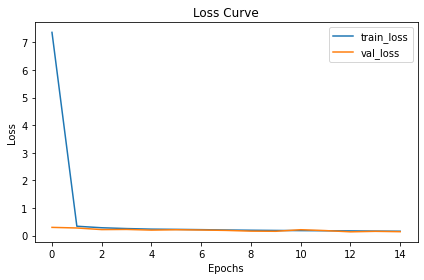

In [10]:
plt.plot(sub_history.history['loss'], label='train_loss')
plt.plot(sub_history.history['val_loss'], label='val_loss')
plt.title("Loss Curve")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

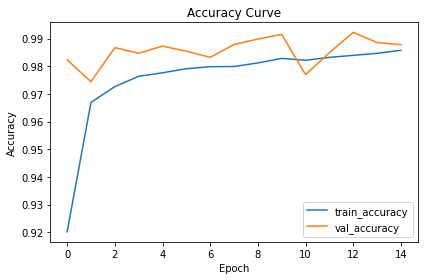

In [11]:
plt.plot(sub_history.history['accuracy'], label='train_accuracy')
plt.plot(sub_history.history['val_accuracy'], label='val_accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [12]:
sub_model.evaluate(sub_test)
sub_model.save("/models/models/model_category")

170/170 [==============================] - 56s 312ms/step - loss: 0.1454 - accuracy: 0.9893


2022-07-18 17:25:22.484521: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/zkahmad/Library/CloudStorage/GoogleDrive-zebakarin@gmail.com/My Drive/Masters/Sem 2/DS/Project/outfit_recommendation_miniproject/Run/models/models/model_category/assets
